# In this notebook, we show a regression example using the employee dataset. In this problem, the target variable is "salary_growth" that represents the amount of increase in an employee's salary. The explanatory variables include age, edu, jobtime, prevexp, minority, gender, and jobcat. Definition of these explanatory variables is presented in 


In [2]:
import pandas as pd
import numpy as np
import warnings
import scipy
import matplotlib.pyplot as plt
from safeaipackage import check_accuracy, check_robustness, check_explainability, check_fairness, check_privacy
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 10000)

In [3]:
data = pd.read_excel("D:/files/research_activities/ORGANIZED_FILES/safeaipackage/examples/employee.xlsx")
print("This dataset has {} rows and {} columns".format(data.shape[0], data.shape[1]))
data.head()

This dataset has 473 rows and 9 columns


,salary,age,edu,startsal,jobtime,prevexp,minority,gender,jobcat
0,57000,36,15,27000,98,144,no_min,m,manager
1,40200,30,16,18750,98,36,no_min,m,Clerical
2,21450,59,12,12000,98,381,no_min,f,Clerical
3,21900,41,8,13200,98,190,no_min,f,Clerical
4,45000,33,15,21000,98,138,no_min,m,Clerical


In [4]:
data["gender"] = np.where(data["gender"]=="m", 0, 1)
data["minority"] = np.where(data["minority"]=="no_min", 0, 1)
data = pd.get_dummies(data, columns=["jobcat"])
data.head()

,salary,age,edu,startsal,jobtime,prevexp,minority,gender,jobcat_Clerical,jobcat_Custodial,jobcat_manager
0,57000,36,15,27000,98,144,0,0,0,0,1
1,40200,30,16,18750,98,36,0,0,1,0,0
2,21450,59,12,12000,98,381,0,1,1,0,0
3,21900,41,8,13200,98,190,0,1,1,0,0
4,45000,33,15,21000,98,138,0,0,1,0,0


In [5]:
data["salary_growth"] = data["salary"]-data["startsal"]

data.drop(["salary", "startsal"], axis=1, inplace=True)
data.head()

,age,edu,jobtime,prevexp,minority,gender,jobcat_Clerical,jobcat_Custodial,jobcat_manager,salary_growth
0,36,15,98,144,0,0,0,0,1,30000
1,30,16,98,36,0,0,1,0,0,21450
2,59,12,98,381,0,1,1,0,0,9450
3,41,8,98,190,0,1,1,0,0,8700
4,33,15,98,138,0,0,1,0,0,24000


In [6]:
X = data.drop(["salary_growth"], axis=1)
y = data["salary_growth"]

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=1)

print(xtrain.shape)

(331, 9)


In [7]:
ann_full = MLPRegressor(random_state=1).fit(xtrain, ytrain)

yhat = ann_full.predict(xtest)
yhat

array([ 3953.9401448 ,  2649.5728026 ,  5670.15745654,  2652.09287437,
        2639.15008448,  2473.63287694,  5814.9851976 ,  3456.35684027,
        3222.19515467,  6067.69857788,  2556.8146545 ,  3198.40595931,
        2598.30220343, 11024.54892796,  2855.97454025,  8094.00262865,
        2681.46386069,  3484.34115342,  2189.16762331,  3212.47175565,
        2616.31784594,  3578.2573465 ,  8363.05761723,  5986.12407982,
        6164.56654738,  6210.03723025,  2532.27138063,  5851.18520695,
        2670.90466419,  3614.97556115,  2700.07969269,  2412.77851204,
        4659.20730621,  8661.68978784,  3120.05559088,  2586.61232513,
        8684.1935276 , 10710.22886449,  2803.70575483,  4465.38451791,
        2655.15364948,  3597.72227381,  3674.58615885,  2939.12365787,
        4564.293529  ,  4585.11836207, 11368.53608657,  2828.67862207,
        3638.06802452,  3176.40253847,  3530.49489338,  2967.10939425,
        3234.81811061,  2365.84932451,  9321.64597015,  3166.69229478,
      

# ACCURACY

## To check accuracy of the classification model, we can use the rga function defined in the "check_accuracy" module of "safeaipackage" python package

In [8]:
#ACCURACY
#rga = check_accuracy.rga(ytest, yhat)
#rga

In [8]:
def rga(y, yhat):
    """
     ### RANK GRADUATION ACCURACY (RGA) MEASURE ###
     Function for the RGE measure computation
     Inputs: y -> observed target variable values; 
             yhat -> predictions generated by the applied selected model
    """ 
    y = pd.DataFrame(y).reset_index(drop=True)
    yhat = pd.DataFrame(yhat).reset_index(drop=True)
    df = pd.concat([y,yhat], axis=1)
    df.columns = ["y", "yhat"]
    ryhat = yhat.rank(method="min")
    df["ryhat"] = ryhat
    support = df.groupby('ryhat')['y'].mean().reset_index(name='support')
    rord = list(range(len(y)))
    for jj in range(len(rord)):
        for ii in range(len(support)):
                if df["ryhat"][jj]== support['ryhat'][ii]:
                    rord[jj] = support['support'][ii]
    vals = [[i, values] for i, values in enumerate(df["yhat"])]
    ranks = [x[0] for x in sorted(vals, key= lambda item: item[1])]
    ystar = [rord[i] for i in ranks]
    I = list(range(len(y)))
    conc = 2*sum([I[i]*ystar[i] for i in range(len(I))])
    dec= 2*sum([sorted(df["y"], reverse=True)[i]*I[i] for i in range(len(I))]) 
    inc = 2*sum([sorted(df["y"])[i]*I[i] for i in range(len(I))]) 
    RGA=(conc-dec)/(inc-dec)
    return RGA 

In [9]:
rga(ytest, yhat)

0.44783766135222947

#### The higher RGA value (closer to one) the better concordance between the trained model and the actual values

## "check_accuracy" module includes the rga_statistic_test function that is an RGA based test for comparing the predictive accuracy of a reduced model with that of a more complex model

In [11]:
#rga_pvalues = []
#for i in xtrain.columns:
#    xtrain_rm = xtrain.drop(i, axis=1)
#    xtest_rm = xtest.drop(i, axis=1)
#    model_rm = rf_model_full.fit(xtrain_rm, ytrain)
#    yhat_rm = model_rm.predict(xtest_rm)
#    rga_pvalues.append(check_accuracy.rga_statistic_test(ytest, yhat_rm, yhat))
#print(pd.DataFrame(rga_pvalues, index=xtest.columns, columns=["P_value"]))

In [10]:
def _delta_function(data, func):
        result = (func(data.iloc[:,0], data.iloc[:,2]))-(func(data.iloc[:,0], data.iloc[:,1]))
        return result

In [11]:
def rga_statistic_test(y, yhat_rm, yhat_cm):
        """
        RGA based test for comparing the predictive accuracy of a reduced model with that of a more complex model
        """
        y = pd.DataFrame(y).reset_index(drop=True)
        yhat_rm = pd.DataFrame(yhat_rm).reset_index(drop=True)
        yhat_cm = pd.DataFrame(yhat_cm).reset_index(drop=True)
        jk_mat = pd.concat([y,yhat_rm, yhat_cm], axis=1)
        jk_mat.columns = ["y", "yhat_rm", "yhat_cm"]
        n = len(jk_mat)
        index = np.arange(n)
        jk_results = []
        for i in range(n):
            jk_sample = jk_mat.drop(labels= i)
            jk_sample.reset_index(drop=True, inplace=True)
            jk_statistic = _delta_function(jk_sample, rga)
            jk_results.append(jk_statistic)
        se = np.sqrt(((n-1)/n)*(sum([(x-np.mean(jk_results))**2 for x in jk_results])))
        z = (rga(y,yhat_cm)-rga(y,yhat_rm))/se
        p_value = 2*scipy.stats.norm.cdf(-abs(z))
        return p_value

In [13]:
rga_pvalues = []
for i in xtrain.columns:
    xtrain_rm = xtrain.drop(i, axis=1)
    xtest_rm = xtest.drop(i, axis=1)
    model_rm = ann_full.fit(xtrain_rm, ytrain)
    yhat_rm = model_rm.predict(xtest_rm)
    rga_pvalues.append(rga_statistic_test(ytest, yhat_rm, yhat))
print(pd.DataFrame(rga_pvalues, index=xtest.columns, columns=["P_value"]))

                   P_value
age               0.422920
edu               0.000451
jobtime           0.324321
prevexp           0.033590
minority          0.207937
gender            0.095277
jobcat_Clerical   0.026258
jobcat_Custodial  0.588315
jobcat_manager    0.015082


# EXPLAINABILITY

# To find the contribution of explanatory variables to the output of the model, we can use the rge function defined in the "check_explainability" module of "safeaipackage" python package

In [16]:
#check_explainability.rge(xtrain, xtest, ytrain, ytest, rf_model_full)

In [14]:
def rge(xtrain, xtest, ytrain, ytest, model):
    """
     ### RANK GRADUATION EXPLAINABILITY (RGE) MEASURE ###
     Function for the RGE measure computation
     Inputs: xtrain, xtest, ytrain, ytest -> the train and test data selected for training and testing the model; 
             model -> a classification or regression model. For example RandomForestClassifier() in ensemble module of sklearn.
    """    
    xtrain = pd.DataFrame(xtrain).reset_index(drop=True)
    xtest = pd.DataFrame(xtest).reset_index(drop=True)
    ytrain = pd.DataFrame(ytrain).reset_index(drop=True)
    ytest = pd.DataFrame(ytest).reset_index(drop=True)
    rge_list = []
    model_full = model.fit(xtrain, ytrain)
    yhat = model_full.predict(xtest)
    for i in xtrain.columns:
         xtrain_rm = xtrain.drop(i, axis=1)
         xtest_rm = xtest.drop(i, axis=1)
         model_rm = model.fit(xtrain_rm, ytrain)
         yhat_rm = model_rm.predict(xtest_rm)
         rge_list.append(1-(rga(yhat, yhat_rm)))
    rge_df = pd.DataFrame(rge_list, index=xtest.columns, columns=["RGE"]).sort_values(by="RGE", ascending=False)
    plt.figure(figsize=(10, 6))
    plt.barh(rge_df.index, rge_df["RGE"])
    plt.xlabel("RGE (Feature Importance)")
    plt.ylabel("Feature")
    plt.title("RGE")
    plt.show()
    return rge_df

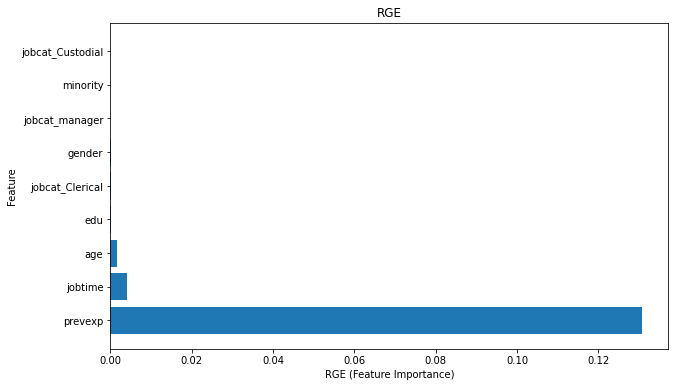

,RGE
prevexp,0.130697
jobtime,0.003968
age,0.001621
edu,0.000180
jobcat_Clerical,0.000018
gender,0.000013
jobcat_manager,0.000011
minority,0.000009
jobcat_Custodial,0.000005


In [17]:
rge(xtrain, xtest, ytrain, ytest, ann_full)

## Here, "jobtime" has the highest contribution with a value equal to 0.211268. This value means that...

# RGE test

In [18]:
xtrain_age = xtrain.drop("age", axis=1)
xtest_age = xtest.drop("age", axis=1)

ann_model_age = MLPRegressor(random_state=1).fit(xtrain_age, ytrain)
yhat_age = ann_model_age.predict(xtest_age)

In [19]:
def rge_num(yhat, yhat_xk):
    yhat = pd.DataFrame(yhat).reset_index(drop=True)
    yhat_xk = pd.DataFrame(yhat_xk).reset_index(drop=True)
    df = pd.concat([yhat,yhat_xk], axis=1)
    df.columns = ["yhat", "yhat_xk"]
    ryhat_xk = yhat_xk.rank(method="min")
    df["ryhat_xk"] = ryhat_xk
    support = df.groupby('ryhat_xk')['yhat'].mean().reset_index(name='support')
    rord = list(range(len(yhat)))
    for jj in range(len(rord)):
        for ii in range(len(support)):
                if df["ryhat_xk"][jj]== support['ryhat_xk'][ii]:
                    rord[jj] = support['support'][ii]
    vals = [[i, values] for i, values in enumerate(df["yhat_xk"])]
    ranks = [x[0] for x in sorted(vals, key= lambda item: item[1])]
    ystar = [rord[i] for i in ranks]
    I = list(range(len(yhat)))
    conc = 2*sum([I[i]*ystar[i] for i in range(len(I))])
    dec= 2*sum([sorted(df["yhat"], reverse=True)[i]*I[i] for i in range(len(I))]) 
    inc = 2*sum([sorted(df["yhat"])[i]*I[i] for i in range(len(I))]) 
    RGE_num=(conc-dec)
    return RGE_num 

In [20]:
def rge_den(yhat):
    yhat = pd.DataFrame(yhat)
    yhat.columns = ["yhat"]
    I = list(range(len(yhat)))
    dec= 2*sum([yhat.sort_values(by="yhat", ascending=False, ignore_index=True).iloc[i,0]*I[i] for i in range(len(I))]) 
    inc = 2*sum([yhat.sort_values(by="yhat", ignore_index=True).iloc[i,0]*I[i] for i in range(len(I))]) 
    RGE_den=(inc-dec)
    return RGE_den

In [21]:
def delta_function(data):
    return rge_den(data.iloc[:,0])-rge_num(data.iloc[:,0], data.iloc[:,1])

In [22]:
def rge_statistic_test(yhat, yhat_xk):
        yhat = pd.DataFrame(yhat).reset_index(drop=True)
        yhat_xk = pd.DataFrame(yhat_xk).reset_index(drop=True)
        jk_mat = pd.concat([yhat, yhat_xk], axis=1, keys=["yhat", "yhat_xk"])
        n = len(jk_mat)
        index = np.arange(n)
        jk_results = []
        for i in range(n):
            jk_sample = jk_mat.iloc[[x for x in index if x != i],:]
            jk_sample.reset_index(drop=True, inplace=True)
            jk_statistic = delta_function(jk_sample)
            jk_results.append(jk_statistic)
        se = np.sqrt(((n-1)/n)*(sum([(x-np.mean(jk_results))**2 for x in jk_results])))
        z = (rge_den(yhat)-rge_num(yhat,yhat_xk))/se
        p_value = 2*scipy.stats.norm.cdf(-abs(z))
        return p_value

In [23]:
rge_statistic_test(yhat, yhat_age)

0.012896120888167667

# ROBUSTNESS

In [53]:
#check_robustness.rgr(xtrain, xtest, ytrain, ytest, rf_model_full)

In [24]:
def rgr(xtrain, xtest, ytrain, ytest, model):    
    xtrain = pd.DataFrame(xtrain).reset_index(drop=True)
    xtest = pd.DataFrame(xtest).reset_index(drop=True)
    ytrain = pd.DataFrame(ytrain).reset_index(drop=True)
    ytest = pd.DataFrame(ytest).reset_index(drop=True)
    model_full = model.fit(xtrain, ytrain)
    yhat = model_full.predict(xtest)
    rgr_vals = []
    for i in range(xtrain.shape[1]):
        perturbed_xtrain = xtrain.reset_index(drop=True)
        variable_perturbed = perturbed_xtrain.iloc[:,i]
        sorted_data = np.sort(variable_perturbed)
        percentile_5_index = int(np.ceil(0.15 * len(sorted_data)))
        percentile_95_index = int(np.ceil(0.85 * len(sorted_data)))
        values_before_5th_percentile = sorted_data[:percentile_5_index]
        values_after_95th_percentile = sorted_data[percentile_95_index:]
        vals = [[i, values] for i, values in enumerate(variable_perturbed)]
        indices = [x[0] for x in sorted(vals, key= lambda item: item[1])]
        lower_tail = indices[0:10]
        upper_tail = (indices[-10:])
        upper_tail = upper_tail[::-1]
        perturbed_variable = variable_perturbed.copy()
        for j in range(10):
            perturbed_variable[lower_tail[j]] = variable_perturbed[upper_tail[j]]
            perturbed_variable[upper_tail[j]] = variable_perturbed[lower_tail[j]]
        perturbed_xtrain.iloc[:,i] = perturbed_variable
        rf_perturbed = model.fit(perturbed_xtrain, ytrain)
        yhat_pert = rf_perturbed.predict(xtest)
        rgr_vals.append(rga(yhat, yhat_pert))
    rgr_df = pd.DataFrame(rgr_vals, index=xtest.columns, columns=["RGR"]).sort_values(by="RGR", ascending=False)
    return rgr_df

In [26]:
rgr(xtrain, xtest, ytrain, ytest, ann_full)

,RGR
edu,1.0
jobtime,1.0
prevexp,1.0
minority,1.0
gender,1.0
jobcat_Custodial,1.0
jobcat_manager,1.0
age,1.0
jobcat_Clerical,1.0


## RGR test

In [27]:
### to need the rgr test, I need to have another model results

from sklearn.linear_model import LinearRegression

regression_model = LinearRegression().fit(xtrain,ytrain)
reg_predictions_full = regression_model.predict(xtest)

In [33]:
def rgr_statistic_test(yhat_mod1,yhat_mod2,yhat_pert_mod1,yhat_pert_mod2):
        yhat_mod1 = pd.DataFrame(yhat_mod1).reset_index(drop=True)
        yhat_mod2 = pd.DataFrame(yhat_mod2).reset_index(drop=True)
        yhat_pert_mod1 = pd.DataFrame(yhat_pert_mod1).reset_index(drop=True)
        yhat_pert_mod2 = pd.DataFrame(yhat_pert_mod2).reset_index(drop=True)
        jk_mat = pd.concat([yhat_mod1,yhat_mod2,yhat_pert_mod1,yhat_pert_mod2], axis=1, keys=["yhat_mod1", 
                                                                                        "yhat_mode2", 
                                                                                        "yhat_pert_mode1",
                                                                                        "yhat_pert_mode2"])
        n = len(jk_mat)
        index = np.arange(n)
        jk_results = []
        for i in range(n):
            jk_sample = jk_mat.iloc[[x for x in index if x != i],:]
            jk_sample.reset_index(drop=True, inplace=True)
            jk_statistic = _delta_function(jk_sample, rga)
            jk_results.append(jk_statistic)
        se = np.sqrt(((n-1)/n)*(sum([(x-np.mean(jk_results))**2 for x in jk_results])))
        z = (rga(yhat_mod1, yhat_pert_mod1)- rga(yhat_mod2, yhat_pert_mod2))/se
        p_value = 2*scipy.stats.norm.cdf(-abs(z))
        return p_value

In [59]:
#xtrain_pert = xtrain.copy()
#rgr_pvalues = []
#for i in xtrain.columns:
#    xtrain_pert[i] = np.random.permutation(xtrain[i])
#    rf_perturbed = RandomForestClassifier(random_state=1).fit(xtrain_pert, ytrain)
#    lr_perturbed = LogisticRegression(random_state=1).fit(xtrain_pert, ytrain)
#    rf_yhat_pert = rf_perturbed.predict(xtest)
#    lr_yhat_pert = lr_perturbed.predict(xtest)
#    rgr_pvalues.append(check_robustness.rgr_statistic_test(rf_predictions_full,lr_predictions_full,rf_yhat_pert,lr_yhat_pert))
#print(pd.DataFrame(rgr_pvalues, index=xtrain.columns, columns=["P_value"]))

In [34]:
xtrain_pert = xtrain.copy()
rgr_pvalues = []
for i in xtrain.columns:
    xtrain_pert[i] = np.random.permutation(xtrain[i])
    rf_perturbed = MLPRegressor(random_state=1).fit(xtrain_pert, ytrain)
    lr_perturbed = LinearRegression().fit(xtrain_pert, ytrain)
    rf_yhat_pert = rf_perturbed.predict(xtest)
    lr_yhat_pert = lr_perturbed.predict(xtest)
    rgr_pvalues.append(rgr_statistic_test(yhat,reg_predictions_full,rf_yhat_pert,lr_yhat_pert))
print(pd.DataFrame(rgr_pvalues, index=xtrain.columns, columns=["P_value"]))

                   P_value
age               0.958229
edu               0.912153
jobtime           0.882948
prevexp           0.543995
minority          0.511310
gender            0.652918
jobcat_Clerical   0.614195
jobcat_Custodial  0.548769
jobcat_manager    0.327785


# FAIRNESS

In [27]:
#print(check_fairness.rgf(xtrain, xtest, ytrain, ytest, ["gender", "minority"], rf_model_full))

In [35]:
def rgf(xtrain, xtest, ytrain, ytest, protectedvariables, model):
    """
     ### RANK GRADUATION FAIRNESS (RGF) MEASURE ###
     Function for the RGF measure computation
     Inputs: xtrain, xtest, ytrain, ytest -> the train and test data selected for training and testing the model;
             protectedvariables -> a list of variables should be considered as the protected variables; 
             model -> a classification or regression model. For example RandomForestClassifier() in ensemble module of sklearn.
    """    
    if not isinstance(protectedvariables, list):
        raise ValueError("Protectedvariables input must be a list")
    xtrain = pd.DataFrame(xtrain).reset_index(drop=True)
    xtest = pd.DataFrame(xtest).reset_index(drop=True)
    ytrain = pd.DataFrame(ytrain).reset_index(drop=True)
    ytest = pd.DataFrame(ytest).reset_index(drop=True)
    for i in range(len(list(protectedvariables))):
        if protectedvariables[i] not in xtrain:
            raise ValueError(f"{protectedvariables[i]} is not in the variables")
    rgf_list = []
    model_full = model.fit(xtrain, ytrain)
    yhat = model_full.predict(xtest)
    for i in protectedvariables:
         xtrain_pr = xtrain.drop(i, axis=1)
         xtest_pr = xtest.drop(i, axis=1)
         model_pr = model.fit(xtrain_pr, ytrain)
         yhat_pr = model_pr.predict(xtest_pr)
         rgf_list.append(rga(yhat, yhat_pr))
    return pd.DataFrame(rgf_list, index=protectedvariables, columns=["RGF"]).sort_values(by="RGF", ascending=False)


In [36]:
rgf(xtrain, xtest, ytrain, ytest,["gender", "minority"], ann_full)

,RGF
minority,0.999991
gender,0.999987


# PRIVACY

In [33]:
#print(check_privacy.rgp(xtrain, xtest, ytrain, ytest, rf_model_full))

In [37]:
def rgp(xtrain, xtest, ytrain, ytest, index, model):
    """
     ### RANK GRADUATION PRIVACY (RGP) MEASURE ###
     Function for the RGP measure computation
     Inputs: xtrain, xtest, ytrain, ytest -> the train and test data selected for training and testing the model;
             index -> a list of indices to specify for which observations, privacy should be checked; 
             model -> a classification or regression model. For example RandomForestClassifier() in ensemble module of sklearn.
    """   
    if not isinstance(index, list):
        raise ValueError("Index input must be a list")
    xtrain = pd.DataFrame(xtrain).reset_index(drop=True)
    xtest = pd.DataFrame(xtest).reset_index(drop=True)
    ytrain = pd.DataFrame(ytrain).reset_index(drop=True)
    ytest = pd.DataFrame(ytest).reset_index(drop=True)
    rgp_list = []
    model_full = model.fit(xtrain, ytrain)
    yhat = model_full.predict(xtest)
    for i in index:
        if i in xtrain.index:
            xtrain_rm = xtrain.drop(index=i, axis=0)
            ytrain_rm = ytrain.drop(index=i, axis=0)
            model_rm = model.fit(xtrain_rm, ytrain_rm)
            yhat_rm = model_rm.predict(xtest)
            rgp_list.append((1-rga(yhat, yhat_rm)))
        else:
            raise ValueError(f"index {i} is not available")
    return pd.DataFrame(rgp_list, index=index, columns=["RGP"])

In [39]:
rgp(xtrain, xtest, ytrain, ytest, [10,12], ann_full)

,RGP
10,0.0
12,0.0


# ###########

In [47]:
def rgr(xtrain, xtest, ytrain, ytest, model):    
    xtrain = pd.DataFrame(xtrain).reset_index(drop=True)
    xtest = pd.DataFrame(xtest).reset_index(drop=True)
    ytrain = pd.DataFrame(ytrain).reset_index(drop=True)
    ytest = pd.DataFrame(ytest).reset_index(drop=True)
    model_full = model.fit(xtrain, ytrain)
    yhat = model_full.predict(xtest)
    rgr_vals = []
    for i in range(xtrain.shape[1]):
        perturbed_xtrain = xtrain.reset_index(drop=True)
        variable_perturbed = perturbed_xtrain.iloc[:,i]
        sorted_data = np.sort(variable_perturbed)
        percentile_5_index = int(np.ceil(0.3 * len(sorted_data)))
        percentile_95_index = int(np.ceil(0.7 * len(sorted_data)))
        values_before_5th_percentile = sorted_data[:percentile_5_index]
        values_after_95th_percentile = sorted_data[percentile_95_index:]
        vals = [[i, values] for i, values in enumerate(variable_perturbed)]
        indices = [x[0] for x in sorted(vals, key= lambda item: item[1])]
        lower_tail = indices[0:percentile_5_index]
        upper_tail = (indices[-percentile_5_index:])
        upper_tail = upper_tail[::-1]
        for j in range(len(lower_tail)):
            variable_perturbed[lower_tail[j]] = variable_perturbed[upper_tail[j]]
            variable_perturbed[upper_tail[j]] = variable_perturbed[lower_tail[j]]
        perturbed_xtrain.iloc[:,i] = variable_perturbed
        rf_perturbed = model.fit(perturbed_xtrain, ytrain)
        yhat_pert = rf_perturbed.predict(xtest)
        rgr_vals.append(rga(yhat, yhat_pert))
    rgr_df = pd.DataFrame(rgr_vals, index=xtest.columns, columns=["RGR"]).sort_values(by="RGR", ascending=False)
    return rgr_df

In [48]:
rgr(xtrain, xtest, ytrain, ytest, ann_full)

,RGR
jobtime,1.000000
minority,1.000000
gender,1.000000
jobcat_Clerical,1.000000
jobcat_Custodial,1.000000
jobcat_manager,1.000000
edu,1.000000
age,1.000000
prevexp,0.999989
